## <b> KNN Notebook </b>

### <b> Goals </b>

The goals of our project are focused around implementing ways to improve the way the KNN algorithm classifies binary data when consuming datasets that present heavy class imbalances.

### <b> KNN base algorithm </b>

This is the base algorithm along with its classifier and regressor.

In [1]:
from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean
from base import BaseEstimator


class KNNBase(BaseEstimator):
    def __init__(self, k=5, distance_func=euclidean):
        self.k = k
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        distances = [self.distance_func(x, example) for example in self.X]
        neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
        neighbors_targets = [target for (_, target) in neighbors[:self.k]]
        return self.aggregate(neighbors_targets)

    def get_params(self, deep=True):
        return {'k': self.k, 'distance_func': self.distance_func}

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']
        if 'distance_func' in params:
            self.distance_func = params['distance_func']


from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean
from base import BaseEstimator

class KNNClassifier(KNNBase):
    def aggregate(self, neighbors_targets):
        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

    def predict_proba(self, X=None):
        probabilities = []
        n_classes = len(np.unique(self.y))  # Number of unique class labels in training data
        for x in X:
            distances = [self.distance_func(x, example) for example in self.X]
            neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
            neighbors_targets = [target for (_, target) in neighbors[:self.k]]
            class_counts = Counter(neighbors_targets)
            prob = np.zeros(n_classes)
            for class_label, count in class_counts.items():
                prob[class_label] = count / self.k
            probabilities.append(prob)
        return np.array(probabilities)


### <b> Dataset Exploratory Data Analysis </b>

In this section of the notebook our aim is to better understand our dataset.
As previously mentioned our main focus is to tackle KNN problems related to Binary Class Imbalances, therefore we'll start by checking if the datasets we'll be using actually do present those problems.

In [2]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml #Fetch Method for OpenML datasets

##### <b> Functions to extract data and observe binary class imbalances </b>



In [3]:
#Function to fetch datasets and transform them into dataframe
def dataset_fetcher(dataset_id):
    #Fetch OpenML dataset
    dataset = fetch_openml(data_id=dataset_id, version='active', as_frame=True)
    
    dataset_name = dataset.details['name']

    #Convert dataset to pandas dataframe
    df = dataset.frame

    #Change last column name to "class" in all dataframes
    last_column_name = df.columns[-1] 
    df = df.rename(columns={last_column_name: 'class'})


    return df, dataset_name


#Function to show number of entries for each label/class
def item_number_per_class(dataframe, ds_name):

    #Select class column
    label_column = dataframe.iloc[:,-1]
    
    # Count the occurrences of each value
    occurrences = label_column.value_counts()

    return occurrences, ds_name

#Function to plot the data
def plot_number_of_entries_per_class(num_occurrences, dsname):

    
    plt.figure(figsize=(3, 2))

    # Plotting the occurrences as a bar chart
    num_occurrences.plot(kind='bar', rot=0)

    # Adding labels and title
    plt.xlabel('Item')
    plt.ylabel('Count')
    plt.title(f'Occurrences of Each Item in {dsname}')

    # Display the plot
    plt.show()

#Pipline for EDA
def data_generation_pipeline(datasets_id):

    '''
    Function will return a list of dataframes that will then be used to benchmark the algorithm
    '''
    dataframes = []
    for id in datasets_id:
        dataframe, dsname = dataset_fetcher(id)
        dataframes.append(dataframe)
        occurrences, dsname = item_number_per_class(dataframe, dsname)
        plot_number_of_entries_per_class(occurrences, dsname)

    return dataframes
    
    

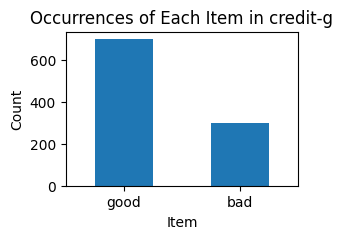

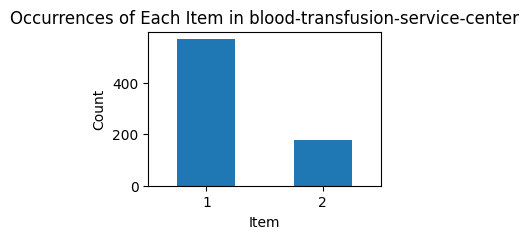

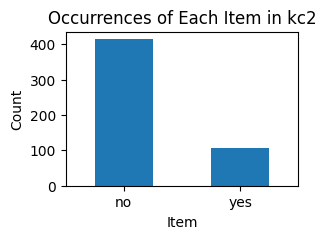

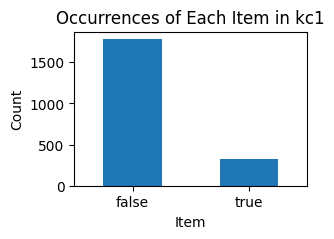

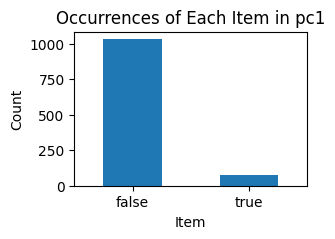

In [4]:
dataset_id_list = [31, 1464, 1063, 1067, 1068]
dataframes = data_generation_pipeline(dataset_id_list)

As displayed above in the graphs, we can clearly see that every single one of the datasets that we are using has severe class imbalances.

#### <b> Convert non-numeric values to numeric values </b>

Since our Classifier only works with numerical values, we need to replace all of the non-numerical entries in our dataframe.
We also want to ensure that in each column, the identity of the unique data points is preserved, meaning that within the same column previously non-numerical values that are the same will also have the same numerical representation.

On top of that, we'll also implement a way to replace non-available values (NaN) by inserting the mean of the column by NaN in a given entry.

In [5]:
from sklearn.preprocessing import LabelEncoder
def encode_non_numerical_and_nan(df):
    df_encoded = df.copy()
    
    for column in df_encoded.columns:
        if pd.api.types.is_object_dtype(df_encoded[column]) or df_encoded[column].apply(lambda x: isinstance(x, str)).any():
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df_encoded[column])

    # Replace NaN values with the mean of the column
    for column in df_encoded.columns:
        if df_encoded[column].isnull().any():
            mean_value = df_encoded[column].mean()
            df_encoded[column].fillna(mean_value, inplace=True)
    
    return df_encoded

In [6]:
dataframerinos = []

for id in dataset_id_list:
    dfx = dataset_fetcher(id)[0]
    dfx_encoded = encode_non_numerical_and_nan(dfx)
    dfx_encoded.tail()
    dataframerinos.append(dfx_encoded)


### <b> Performance of the base KNN Algorithm </b>

Now, we'll benchmark the base implementation of the KNN algorithm, using some well defined metrics, to see how it performs when we feed it the previously chosen datasets.

In [7]:
from collections import Counter
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

class KNNBaseOp(BaseEstimator):
    def __init__(self, k=5):
        self.k = k

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        distances = np.linalg.norm(self.X - x, axis=1)
        indices = np.argsort(distances)[:self.k]
        neighbors_targets = self.y[indices]
        return self.aggregate(neighbors_targets)

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        return self._predict(X)

    def get_params(self, deep=True):
        return {'k': self.k}

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']

class KNNClassifierOptimized(KNNBaseOp):
    def __init__(self, k=5, class_weights=None):
        super().__init__(k=k)
        self.class_weights = class_weights

    def aggregate(self, neighbors_targets):
        class_weights = self._calculate_class_weights(neighbors_targets)
        weighted_votes = Counter(neighbors_targets)
        for target, weight in zip(neighbors_targets, class_weights):
            weighted_votes[target] += weight
        return weighted_votes.most_common(1)[0][0]

    def _calculate_class_weights(self, neighbors_targets):
        if self.class_weights is None:
            return np.ones(len(neighbors_targets))  # Default equal weights
        else:
            return np.array([self.class_weights.get(target, 1) for target in neighbors_targets])

    def predict_proba(self, X=None):
        probabilities = []
        for x in X:
            distances = np.linalg.norm(self.X - x, axis=1)
            indices = np.argsort(distances)[:self.k]
            neighbors_targets = self.y[indices]
            class_weights = self._calculate_class_weights(neighbors_targets)
            prob = np.zeros(len(np.unique(self.y)))
            for i, class_label in enumerate(np.unique(self.y)):
                class_indices = np.where(neighbors_targets == class_label)[0]
                prob[i] = np.sum(class_weights[class_indices]) / np.sum(class_weights)
            probabilities.append(prob)
        return np.array(probabilities)

In [8]:
def knnBasePerformanceMetrics(dataframe_set, n_splits=5, random_state=42):
    # Separate features from class labels
    X = dataframe_set.drop(columns=['class']).values  # Features as numpy array
    y = dataframe_set['class'].values  # Labels as numpy array

    # Instantiate a classifier
    knn = KNNClassifier(k=9)

    # Define the k-fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store metric scores
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []  # New list for storing AUC-ROC scores

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        knn.fit(X_train, y_train)

        # Make predictions
        y_pred = knn.predict(X_test)

        # Calculate evaluation metrics
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Calculate AUC-ROC
        y_prob = knn.predict_proba(X_test)[:, 1]
        roc_auc_scores.append(roc_auc_score(y_test, y_prob))

    # Calculate mean scores
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)

    return mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc


In [9]:
# Example usage:
for df in dataframerinos:
    mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc= knnBasePerformanceMetrics(df, n_splits=5)
    print(f"Mean Accuracy: {mean_accuracy}, Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1 Score: {mean_f1}, Mean ROC-AUC: {mean_roc_auc}")

Mean Accuracy: 0.675, Mean Precision: 0.7145139499055161, Mean Recall: 0.8931415479270444, Mean F1 Score: 0.7934336756039526, Mean ROC-AUC: 0.5827875274880039
Mean Accuracy: 0.7701476510067115, Mean Precision: 0.544927536231884, Mean Recall: 0.279137811759763, Mean F1 Score: 0.3659003496503496, Mean ROC-AUC: 0.6735606381898774
Mean Accuracy: 0.8218864468864469, Mean Precision: 0.6097285067873303, Mean Recall: 0.3967380952380953, Mean F1 Score: 0.47218566723210686, Mean ROC-AUC: 0.8088919075187577
Mean Accuracy: 0.8330954283977439, Mean Precision: 0.422925479020131, Mean Recall: 0.19545738414590877, Mean F1 Score: 0.262397870920695, Mean ROC-AUC: 0.7337498107361317
Mean Accuracy: 0.9314703844115609, Mean Precision: 0.5666666666666667, Mean Recall: 0.10033834586466166, Mean F1 Score: 0.16942313157146918, Mean ROC-AUC: 0.6181179824578191


### <b> KNN modified algorithm </b>

First, we need to implement techniques such as oversampling of minority class instances or undersampling of majority class instances.

In [10]:
from collections import Counter
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

class KNNBaseOp(BaseEstimator):
    def __init__(self, k=5):
        self.k = k

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        distances = np.linalg.norm(self.X - x, axis=1)
        indices = np.argsort(distances)[:self.k]
        neighbors_targets = self.y[indices]
        return self.aggregate(neighbors_targets)

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        return self._predict(X)

    def get_params(self, deep=True):
        return {'k': self.k}

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']

class KNNClassifierOptimized(KNNBaseOp):
    def __init__(self, k=5, class_weights=None):
        super().__init__(k=k)
        self.class_weights = class_weights

    def aggregate(self, neighbors_targets):
        class_weights = self._calculate_class_weights(neighbors_targets)
        weighted_votes = Counter(neighbors_targets)
        for target, weight in zip(neighbors_targets, class_weights):
            weighted_votes[target] += weight
        return weighted_votes.most_common(1)[0][0]

    def _calculate_class_weights(self, neighbors_targets):
        if self.class_weights is None:
            return np.ones(len(neighbors_targets))  # Default equal weights
        else:
            return np.array([self.class_weights.get(target, 1) for target in neighbors_targets])

    def predict_proba(self, X=None):
        probabilities = []
        for x in X:
            distances = np.linalg.norm(self.X - x, axis=1)
            indices = np.argsort(distances)[:self.k]
            neighbors_targets = self.y[indices]
            class_weights = self._calculate_class_weights(neighbors_targets)
            prob = np.zeros(len(np.unique(self.y)))
            for i, class_label in enumerate(np.unique(self.y)):
                class_indices = np.where(neighbors_targets == class_label)[0]
                prob[i] = np.sum(class_weights[class_indices]) / np.sum(class_weights)
            probabilities.append(prob)
        return np.array(probabilities)


With all the new features implemented, we can now make the test

In [11]:
def knnPerformanceMetrics(dataframe_set, n_splits=5, random_state=42):
    X = dataframe_set.drop(columns=['class']).values
    y = dataframe_set['class'].values

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}

    knn = KNNClassifierOptimized(k=9, class_weights=class_weights_dict)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        y_prob = knn.predict_proba(X_test)[:, 1]
        roc_auc_scores.append(roc_auc_score(y_test, y_prob))

    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)

    return mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc

# Evaluate on your datasets
for df in dataframerinos:
    mean_accuracy, mean_precision, mean_recall, mean_f1,  mean_roc_auc = knnPerformanceMetrics(df, n_splits=5)
    print(f"Mean Accuracy: {mean_accuracy}, Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1 Score: {mean_f1}, Mean ROC-AUC: { mean_roc_auc}")

Mean Accuracy: 0.632, Mean Precision: 0.736581947367334, Mean Recall: 0.7403827801344888, Mean F1 Score: 0.7375447215563082, Mean ROC-AUC: 0.5828435438495806
Mean Accuracy: 0.7299597315436243, Mean Precision: 0.4376002944423997, Mean Recall: 0.4193534025851099, Mean F1 Score: 0.4195916122781795, Mean ROC-AUC: 0.6802210991590665
Mean Accuracy: 0.7798168498168498, Mean Precision: 0.4778925459072518, Mean Recall: 0.6670238095238095, Mean F1 Score: 0.5509298245614035, Mean ROC-AUC: 0.7978295470689188
Mean Accuracy: 0.7837815627427362, Mean Precision: 0.35606213565961614, Mean Recall: 0.5148839684905259, Mean F1 Score: 0.41914497992144606, Mean ROC-AUC: 0.7486478945872026
Mean Accuracy: 0.8386001386001386, Mean Precision: 0.16284943127048387, Mean Recall: 0.32714623096202045, Mean F1 Score: 0.21624565520030187, Mean ROC-AUC: 0.6201619408169934
